In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import random
import seaborn as sns
#import matplotlib as mpl
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 1

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Utility function to create folders and callbacks for training
from datetime import datetime

exp_dir = ''

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%Y-%m-%d_%H:%M')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tfk.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                save_weights_only=False,
                                                save_best_only=False)
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)
  callbacks.append(tb_callback)

In [4]:
#!unzip ANN_HW1.zip
#import zipfile
#with zipfile.ZipFile("dataset.zip", 'r') as z:
#    z.extractall()

In [5]:
# Set the path to the dataset 

dataset_dir = '../input/homework1split/'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [6]:
# Plot example images from dataset
'''
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
    if i < len(labels):
        class_imgs = next(os.walk('{}/{}/'.format(training_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(training_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()
'''

"\nlabels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']\n\nnum_row = len(labels)//2\nnum_col = len(labels)//num_row\nfig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))\nfor i in range(len(labels)):\n    if i < len(labels):\n        class_imgs = next(os.walk('{}/{}/'.format(training_dir, labels[i])))[2]\n        class_img = class_imgs[0]\n        img = Image.open('{}/{}/{}'.format(training_dir, labels[i], class_img))\n        ax = axes[i//num_col, i%num_col]\n        ax.imshow(np.array(img))\n        ax.set_title('{}'.format(labels[i]))\nplt.tight_layout()\nplt.show()\n"

In [7]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)  
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

train_dataset = train_gen.flow_from_directory(directory=training_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=8,
                                                shuffle=True,
                                                class_mode='categorical',
                                                seed=seed)


valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)   

validation_dataset = valid_gen.flow_from_directory(directory=validation_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=8,
                                                shuffle=True,
                                                class_mode='categorical',
                                                seed=seed)

Found 14176 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [8]:
input_shape = (256, 256, 3)
epochs = 150
model_name = 'vgg16'

In [9]:
def build_model(input_shape):
#create model
    model = tfk.applications.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
    for layer in model.layers:
        layer.trainable = False
    
    flatten = tfkl.Flatten()(model.layers[-1].output)
    dropout = tfkl.Dropout(0.5, seed=seed)(flatten)
    dense = tfkl.Dense(512, 
                       activation='relu',
                       kernel_initializer=tfk.initializers.GlorotUniform(seed), 
                       kernel_regularizer = tfk.regularizers.l2(0.001))(dropout)
    dropout = tfkl.Dropout(0.25, seed=seed)(dense)
    output = tfkl.Dense(14, activation='softmax')(dropout)
    model = tfk.Model(inputs=model.input, outputs=output)
    

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), 
                  optimizer=tfk.optimizers.Adam(0.0001), metrics='accuracy')

    # Return the model
    return model

2021-11-22 08:33:29.412016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 08:33:29.532259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 08:33:29.533342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 08:33:29.535118: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

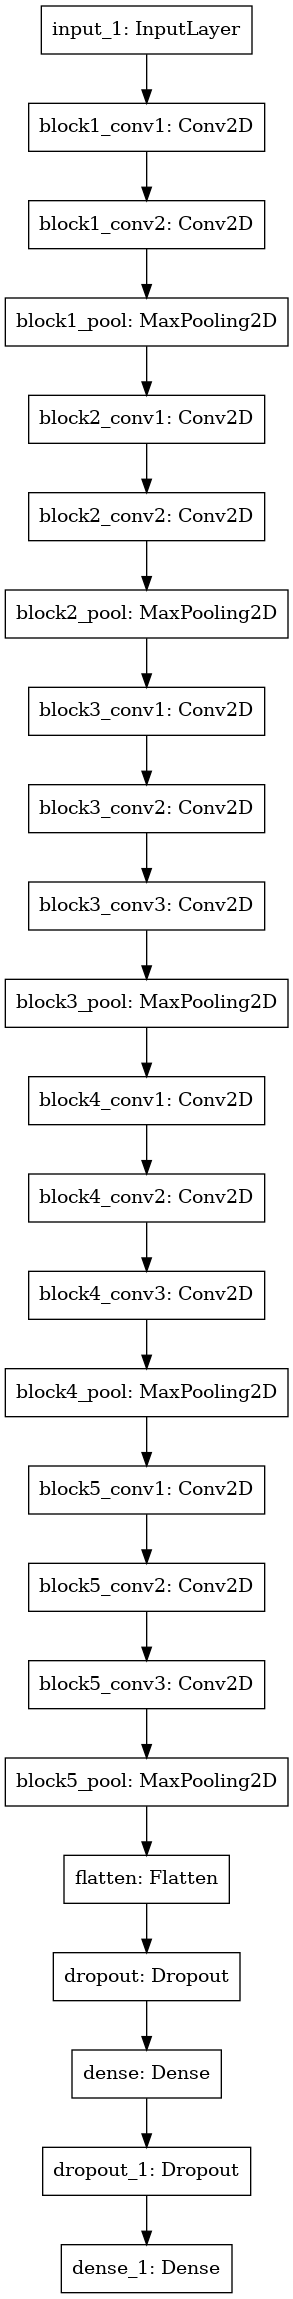

In [10]:
model = build_model(input_shape)
model.summary()
tfk.utils.plot_model(model)

In [11]:
callbacks = create_folders_and_callbacks(model_name=model_name)

# Train the model
history = model.fit(
    x = train_dataset,
    epochs = epochs,
    batch_size = 256,
    validation_data = validation_dataset,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

2021-11-22 08:33:34.587779: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2021-11-22 08:33:36.949620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1772/1772 [==============================] - 189s 102ms/step - loss: 1.7460 - accuracy: 0.8684 - val_loss: 0.7266 - val_accuracy: 0.9566
Epoch 2/150
1772/1772 [==============================] - 78s 44ms/step - loss: 0.7844 - accuracy: 0.9524 - val_loss: 0.6203 - val_accuracy: 0.9780
Epoch 3/150
1772/1772 [==============================] - 82s 46ms/step - loss: 0.6914 - accuracy: 0.9656 - val_loss: 0.6104 - val_accuracy: 0.9775
Epoch 4/150
1772/1772 [==============================] - 80s 45ms/step - loss: 0.5967 - accuracy: 0.9758 - val_loss: 0.5353 - val_accuracy: 0.9803
Epoch 5/150
1772/1772 [==============================] - 80s 45ms/step - loss: 0.5432 - accuracy: 0.9791 - val_loss: 0.5834 - val_accuracy: 0.9744
Epoch 6/150
1772/1772 [==============================] - 83s 47ms/step - loss: 0.5385 - accuracy: 0.9771 - val_loss: 0.5740 - val_accuracy: 0.9775
Epoch 7/150
1772/1772 [==============================] - 82s 46ms/step - loss: 0.4652 - accuracy: 0.9830 - val_loss: 0.5099 - va

In [12]:
# Save the model
model.save(os.path.join(exp_dir, model_name))

2021-11-22 09:01:17.176582: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


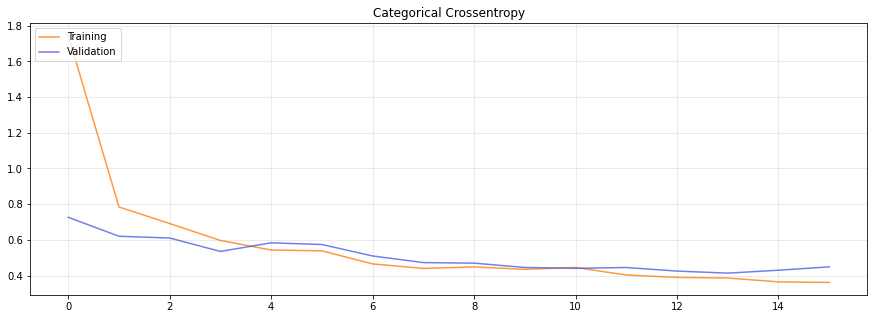

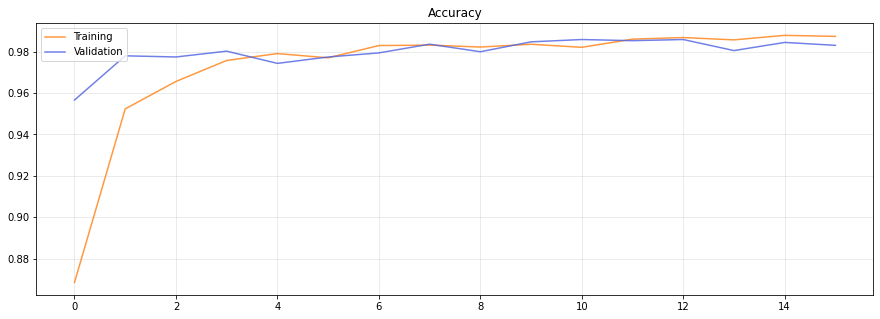

In [13]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()